In [13]:
# BEGIN PRELUDE

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, Aer
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.circuit import Instruction

print("qiskit-imports", end="")

from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

print(", qiskit-ibm-imports", end="")

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

print(", qiskit-runtime-service", end="")

import numpy as np

from dataclasses import dataclass
import pickle as pkl
from math import pi, cos, sin, tan, acos, asin, atan, atan2, log, log2, sqrt

print(", misc-imports", end="")

def simulate_quantum_circuit(circuit, shots=1024, method="ibm_qasm_simulator"):
    simulator = service.backends(filters=lambda x: x.name == method)[0]
    compiled_circuit = transpile(circuit, simulator)
    sampler = Sampler(session=simulator)
    job = sampler.run(compiled_circuit, shots=shots)
    result = job.result()
    return result

print(", and helper-functions", end="")

print(" have been loaded. ")

import random
import matplotlib.pyplot as plt
import matplotlib.animation as mpl_animation
QCirc, QInstr, QReg, CReg = QuantumCircuit, Instruction, QuantumRegister, ClassicalRegister

# END PRELUDE

qiskit-imports, qiskit-ibm-imports, qiskit-runtime-service, misc-imports, and helper-functions have been loaded. 


In [29]:
def run(CHUNK_NUMBER: int):
    # Set how many bits we are going to use to represent X, Y, and t coordinates
    bits_x = 5
    bits_y = 5
    bits_t = 3

    # Set how many boxes there are:
    log2_n_boxes = 4
    n_boxes = 1 << log2_n_boxes

    # Convert a positive integer into bits, erroring on overflow
    def as_bits(n_orig: int, bits: int):
        n = n_orig
        result = []
        for i in range(bits - 1, -1, -1):
            power = 1 << i
            if n >= power:
                n -= power
                result.append(True)
            else:
                result.append(False)
        if n != 0:
            raise RuntimeError("Overflow (or logic error) in as_bits.")
        return result[::-1]

    assert as_bits(23, 5)[::-1] == [True, False, True, True, True]

    import sys
    print("Loading Box, BoxCfg, EncodedChunk...", end="")
    sys.stdout.flush()

    from dataclasses import dataclass
    from math import log2
    import typing

    import numpy as np

    XYT_BITS = (bits_x, bits_y, bits_t)

    MIN_SIZE = 0

    @dataclass(frozen=True)
    class BoxCfg:
        var: tuple[int, int, int]

        def volume(self) -> int:
            return (1 << self.var[0]) * (1 << self.var[1]) * (1 << self.var[2])

        def possible_boxes(self) -> typing.Generator["Box", None, None]:
            for fixed_x in range(0, 1 << (XYT_BITS[0] - self.var[0])):
                for fixed_y in range(0, 1 << (XYT_BITS[1] - self.var[1])):
                    for fixed_t in range(0, 1 << (XYT_BITS[2] - self.var[2])):
                        yield Box(
                            (fixed_x, fixed_y, fixed_t),
                            self,
                        )

        @classmethod
        def subdivided(cls, box_cfgs: list["BoxCfg"]) -> typing.Generator["BoxCfg", None, None]:
            seen = set()
            for cfg in box_cfgs:
                if cfg.var[0] > MIN_SIZE:
                    opt = BoxCfg((cfg.var[0] - 1, cfg.var[1], cfg.var[2]))
                    if opt not in seen:
                        yield opt
                        seen.add(opt)
                if cfg.var[1] > MIN_SIZE:
                    opt = BoxCfg((cfg.var[0], cfg.var[1] - 1, cfg.var[2]))
                    if opt not in seen:
                        yield opt
                        seen.add(opt)
                if cfg.var[2] > MIN_SIZE:
                    opt = BoxCfg((cfg.var[0], cfg.var[1], cfg.var[2] - 1))
                    if opt not in seen:
                        yield opt
                        seen.add(opt)

        @classmethod
        def find_best_box(cls, xyt_ok: np.array, p_threshold: float) -> typing.Union["Box", None]:
            cfgs = [ cls(XYT_BITS) ]
            best_box, best_box_count = None, 0
            while (best_box == None) and (len(cfgs) > 0):
                cfgs = list(BoxCfg.subdivided(cfgs))
                for cfg in cfgs:
                    for box in cfg.possible_boxes():
                        sys.stdout.flush()
                        count, vol = 0, 0
                        for x, y, t in box.member_coords():
                            if xyt_ok[x,y,t]:
                                count += 1
                            vol += 1
                        if (count / vol) > p_threshold:
                            if count > best_box_count:
                                best_box = box
                                count = best_box_count
            return best_box

    @dataclass(frozen=True)
    class Box:
        xyt_fixed: tuple[int, int, int]
        box_cfg: BoxCfg

        def volume(self) -> int:
            return self.box_cfg.volume()

        def member_coords(self) -> typing.Generator[tuple[int, int, int], None, None]:
            for x_offset in range(1 << self.box_cfg.var[0]):
                for y_offset in range(1 << self.box_cfg.var[1]):
                    for t_offset in range(1 << self.box_cfg.var[2]):
                        x = x_offset + (self.xyt_fixed[0] << self.box_cfg.var[0])
                        y = y_offset + (self.xyt_fixed[1] << self.box_cfg.var[1])
                        t = t_offset + (self.xyt_fixed[2] << self.box_cfg.var[2])
                        yield x, y, t

    @dataclass(frozen=True)
    class EncodedChunk:
        boxes: list[Box | None]

    print("done.")

    with open("encoded.pkl", "rb") as f:
        obj = pkl.load(f)
        boxes_fst = [ eval(i) for i in obj[CHUNK_NUMBER] ]
        # look, pickle.load is already unsafe anyway
        # if you're gonna have something be eval-able
        # you might as well commit and have it eval'd twice

    def make_instr_show_depth(qc: QCirc) -> QInstr:
        decomposed = qc
        for i in range(10):
            decomposed = decomposed.decompose()
        print(f"[info] [depth-of] {qc.name} -> {decomposed.depth()}")
        return qc.to_instruction()



    @dataclass(frozen=True)
    class Shift:
        qubit_index_a: int
        qubit_index_b: int
        amount_pr: float

        def ry_angle(self):
            return 2 * asin(sqrt(n_boxes * self.amount_pr))

    def circ_prepare_box_index(n_shifts: int, shifts: list[Shift], box_volumes: list[int]) -> QCirc:
        # Set up our quantum registers
        unweighted_binary_index = QReg(log2_n_boxes)
        unary_index             = QReg(n_boxes)
        index_distribution      = QReg(n_shifts)
        index_distribution_help = QReg(n_shifts)
        # Create a circuit object
        qc = QuantumCircuit(
            unweighted_binary_index, unary_index,
            index_distribution, index_distribution_help,
            name="prepare_box_index",
        )
        # First, we put the unweighted_binary register into a basic, uniform superposition
        qc.h(unweighted_binary_index)
        # Then, we convert this into an unary index
        qc.append(circ_binary_to_unary(n_boxes, log2_n_boxes), [*unweighted_binary_index, *unary_index])
        # Then, we can weight the unary part (not perfectly, but nothing about this is anywhere close to perfect)
        qc.append(circ_weight_unary(n_shifts, shifts, box_volumes), [*unary_index, *index_distribution, *index_distribution_help])
        return qc

    def circ_binary_to_unary(n: int, log2_n: int) -> QInstr:
        # Set up our quantum registers
        binary = QReg(log2_n)
        unary  = QReg(n)
        # Create a circuit object
        qc = QuantumCircuit(binary, unary, name="binary_to_unary")
        # First, we appropriately entangle the first two unary digits
        qc.cx(binary[0], unary[1])
        qc.x(binary[0])
        qc.cx(binary[0], unary[0])
        # Now, we can use a series of CSWAP gates to move the unary digits around
        n_processed = 2
        for i in range(1, log2_n):
            for j in range(n_processed):
                qc.cswap(binary[i], unary[j], unary[j + n_processed])
            n_processed *= 2
        # Return the circuit as an instruction
        return qc.to_instruction()

    def circ_weight_unary(n_shifts: int, shifts: list[Shift], box_volumes: list[int]) -> QInstr:
        # Set up our quantum registers
        unary                   = QReg(n_boxes)
        index_distribution      = QReg(n_shifts)
        index_distribution_help = QReg(n_shifts)
        # Create a circuit object
        qc = QuantumCircuit(unary, index_distribution, index_distribution_help, name="weight_unary")
        # Perform the necessary shifts
        for i, shift in enumerate(shifts):
            qc.ry(shift.ry_angle(), index_distribution[i])
            qc.ccx(unary[shift.qubit_index_b], index_distribution[i], index_distribution_help[i])
            qc.cx(index_distribution_help[i], unary[shift.qubit_index_a])
            qc.cx(index_distribution_help[i], unary[shift.qubit_index_b])
        # Return the circuit as an instruction
        return qc.to_instruction()

    def volume_of(x) -> int:
        if x is None:
            return 0
        return x.volume()

    # First, we need to preprocess the boxes, also giving us n_shifts
    def calculate_shifts(boxes: list[Box]) -> tuple[int, list[Shift]]:
        box_volumes = [ volume_of(box) for box in boxes ]
        desired_box_probabilities = [ volume / sum(box_volumes) for volume in box_volumes ]
        no_shift_threshold = 0.005
        shifts = []
        required_mean = 1 / n_boxes
        box_indices = list(range(len(boxes)))
        remaining_box_indices = box_indices[:]
        random.shuffle(box_indices)
        for i in box_indices:
            if i not in remaining_box_indices:
                continue
            vol = desired_box_probabilities[i]
            best_vol_diff, best_j = float('inf'), None
            for j in remaining_box_indices:
                if j == i:
                    continue
                j_vol = desired_box_probabilities[j]
                vol_mean = (j_vol + vol) / 2
                vol_diff = abs(vol_mean - required_mean)
                if vol_diff < best_vol_diff:
                    best_vol_diff = vol_diff
                    best_j = j
            best_vol = desired_box_probabilities[best_j]
            if best_vol > vol:
                chosen_hi = best_j
                chosen_lo = i
                shift_amount_p = ((best_vol - required_mean) + (required_mean - vol)) / 2
            else:
                chosen_hi = i
                chosen_lo = best_j
                shift_amount_p = ((vol - required_mean) + (required_mean - best_vol)) / 2
            assert desired_box_probabilities[chosen_hi] >= desired_box_probabilities[chosen_lo]
            assert shift_amount_p >= 0
            if shift_amount_p > no_shift_threshold:      # <- Checks if we even need to shift
                if abs(n_boxes * shift_amount_p) <= 1.0: # <- Checks if we can shift
                    shifts.append(Shift(chosen_hi, chosen_lo, shift_amount_p))
            remaining_box_indices.pop(remaining_box_indices.index(i))
            remaining_box_indices.pop(remaining_box_indices.index(best_j))
        n_shifts = len(shifts)
        print(f"[info] actual n_shifts = {n_shifts}")
        return n_shifts, shifts

    def circ_index_to_start(blist: list[Box]) -> QCirc:
        # Quantum registers
        unary_index             = QReg(n_boxes     , name="unary_index")
        x_reg                   = QReg(bits_x      , name="x_reg")
        y_reg                   = QReg(bits_y      , name="y_reg")
        t_reg                   = QReg(bits_t      , name="t_reg")
        regs = (x_reg, y_reg, t_reg)
        # Create circuit object
        qc = QuantumCircuit(unary_index, *regs, name="index_to_start")
        # Actual operation
        for i in range(n_boxes):
            if blist[i] is None:
                continue
            for dim in (0, 1, 2):
                n_var_bits = blist[i].box_cfg.var[dim]
                for j in range(XYT_BITS[dim] - n_var_bits):
                    if as_bits(blist[i].xyt_fixed[dim], XYT_BITS[dim] - n_var_bits)[j]:
                        qc.cx(unary_index[i], regs[dim][j + n_var_bits])
        return qc

    def circ_index_to_offset(blist: list[Box]) -> QCirc:
        # Quantum registers
        unary_index             = QReg(n_boxes     , name="unary_index")
        x_reg                   = QReg(bits_x      , name="x_reg")
        y_reg                   = QReg(bits_y      , name="y_reg")
        t_reg                   = QReg(bits_t      , name="t_reg")
        regs = (x_reg, y_reg, t_reg)
        # Create circuit object
        qc = QuantumCircuit(unary_index, *regs, name="index_to_offset")
        # Actual operation
        for i in range(n_boxes):
            if blist[i] is None:
                continue
            for dim in (0, 1, 2):
                n_var_bits = blist[i].box_cfg.var[dim]
                for j in range(n_var_bits):
                    qc.ch(unary_index[i], regs[dim][j])
        return qc

    # Now, for the overall quantum circuit for a single timeslice
    def circ_main_once(blist: list[Box], just_prepare_box_index: bool = False) -> QInstr | int:
        n_shifts, shifts = calculate_shifts(blist)
        # Let's first make all the necessary registers
        # First the quantum ones
        unweighted_binary_index = QReg(log2_n_boxes, name="unweighted_binary_index")
        unary_index             = QReg(n_boxes     , name="unary_index")
        index_distribution      = QReg(n_shifts    , name="index_distribution")
        index_distribution_help = QReg(n_shifts    , name="index_distribution_help")
        x_reg                   = QReg(bits_x      , name="x_reg")
        y_reg                   = QReg(bits_y      , name="y_reg")
        t_reg                   = QReg(bits_t      , name="t_reg")
        # Create a circuit object
        if just_prepare_box_index:
            qc = QuantumCircuit(
                unweighted_binary_index,
                unary_index,
                index_distribution,
                index_distribution_help,
                name="main_once",
            )
        else:
            qc = QuantumCircuit(
                unweighted_binary_index,
                unary_index,
                index_distribution,
                index_distribution_help,
                x_reg, y_reg, t_reg,
                name="main_once",
            )
        # There are three main steps:
        # 1. Prepare a weighted superposition of unary box index states
        qc.append(make_instr_show_depth(circ_prepare_box_index(n_shifts, shifts, [ volume_of(box) for box in blist ])), [
            *unweighted_binary_index, *unary_index,
            *index_distribution, *index_distribution_help,
        ])
        if just_prepare_box_index:
            return n_shifts, qc.to_instruction()
        # 2. Transform this into a superposition of possible starting points
        qc.append(make_instr_show_depth(circ_index_to_start(blist)), [*unary_index, *x_reg, *y_reg, *t_reg])
        # 3. Transform this into a superposition of offsets
        qc.append(make_instr_show_depth(circ_index_to_offset(blist)), [*unary_index, *x_reg, *y_reg, *t_reg])
        # Return the circuit as an instruction
        return n_shifts, qc.to_instruction()

    def qc_main():
        just_prepare_box_index = False
        n_shifts_fst, main_once_fst = circ_main_once(boxes_fst, just_prepare_box_index=just_prepare_box_index)
        q_fst = QReg(main_once_fst.num_qubits)
        if just_prepare_box_index:
            fst_unary_out = CReg(n_boxes, name="fst_unary_out")
            qc = QuantumCircuit(
                q_fst,
                fst_unary_out,
                name="main",
            )
        else:
            fst_x_out                   = CReg(bits_x, name="fst_x_out")
            fst_y_out                   = CReg(bits_y, name="fst_y_out")
            fst_t_out                   = CReg(bits_t, name="fst_t_out")
            qc = QuantumCircuit(
                q_fst,
                fst_x_out, fst_y_out, fst_t_out,
                name="main",
            )
        qc.append(main_once_fst, q_fst)
        if just_prepare_box_index:
            qc.measure(q_fst[log2_n_boxes:(log2_n_boxes+n_boxes)], fst_unary_out)
        else:
            xyt_offset = log2_n_boxes + n_boxes + n_shifts_fst + n_shifts_fst
            cursor = xyt_offset
            qc.measure(q_fst[cursor:(cursor := cursor + bits_x)], fst_x_out)
            qc.measure(q_fst[cursor:(cursor := cursor + bits_y)], fst_y_out)
            qc.measure(q_fst[cursor:(cursor := cursor + bits_t)], fst_t_out)
            assert cursor == main_once_fst.num_qubits
        return qc

    print("Creating circuit...", end="")
    sys.stdout.flush()
    main = qc_main()
    print("done.")
    print(f"Uses {main.num_qubits} qubits.")

    import time
    method = "simulator_mps"
    print(f"Simulating (method=\"{method}\")...", end="")
    sys.stdout.flush()
    start = time.time()
    n_shots = 4000
    simulation_result = simulate_quantum_circuit(main, shots=n_shots, method=method)
    print(f"done in {time.time()-start}s.")

    def binstr2dec(s: str):
        # Yes, this is a mind-bogglingy stupid way to do this
        # And an unsafe one at that
        # Hopelessly inefficient too
        # Unfortunately it's 11 P.M. and I don't care
        return eval(f'0b{s}')

    def get_coords_from_result(result_keys: list[str]) -> (list[int], list[int], list[int]):
        xs, ys, ts = [], [], []
        for key in result_keys:
            keyb = bin(key)[2:].zfill(sum(XYT_BITS))
            cursor = 0
            ts.append(binstr2dec(keyb[cursor:(cursor := cursor + bits_t)]))
            ys.append(binstr2dec(keyb[cursor:(cursor := cursor + bits_y)]))
            xs.append(binstr2dec(keyb[cursor:(cursor := cursor + bits_x)]))
        return xs, ys, ts

    result = simulation_result.quasi_dists[0]
    proportion_noise_threshold = 0.05
    coords = get_coords_from_result(result.keys())
    print(max(coords[0]), max(coords[1]), max(coords[2]))

    xy_by_time  = [ ([], []) for _ in range((1 << bits_t)) ] # 5 is num of chunks
    for x, y, t in zip(*coords):
        xy_by_time[t][0].append(x)
        xy_by_time[t][1].append(y)
    fig, ax = plt.subplots()
    ax.set_xlim(0, 1 << bits_x)
    ax.set_ylim(0, 1 << bits_y)
    scatter = ax.scatter(*xy_by_time[0][::-1])
    def scatter_ani_draw(frame):
        arr = np.vstack([
            np.array(xy_by_time[frame][1]),
            np.array([ (1 << XYT_BITS[1]) - i for i in xy_by_time[frame][0] ]),
        ]).T
        if arr.size > 0:
            scatter.set_offsets(arr)
        else:
            scatter.set_offsets(np.array([0, 0]))
        return (scatter,)
    scatter_ani = mpl_animation.FuncAnimation(fig, scatter_ani_draw, frames=(1 << bits_t), interval=(1000//7), blit=True) # ITS HERE TOO!!!
    import os
    scatter_ani.save(f"output-chunk-{CHUNK_NUMBER}.gif", writer="pillow")

Loading Box, BoxCfg, EncodedChunk...done.
Creating circuit...[info] actual n_shifts = 1
[info] [depth-of] prepare_box_index -> 99
[info] [depth-of] index_to_start -> 11
[info] [depth-of] index_to_offset -> 30
done.
Uses 35 qubits.
Simulating (method="simulator_mps")...done in 10.083502531051636s.
22 31 7
Loading Box, BoxCfg, EncodedChunk...done.
Creating circuit...[info] actual n_shifts = 3
[info] [depth-of] prepare_box_index -> 100
[info] [depth-of] index_to_start -> 19
[info] [depth-of] index_to_offset -> 115
done.
Uses 39 qubits.
Simulating (method="simulator_mps")...done in 13.38736367225647s.
31 31 7
Loading Box, BoxCfg, EncodedChunk...done.
Creating circuit...[info] actual n_shifts = 6
[info] [depth-of] prepare_box_index -> 108
[info] [depth-of] index_to_start -> 12
[info] [depth-of] index_to_offset -> 115
done.
Uses 45 qubits.
Simulating (method="simulator_mps")...done in 16.647451162338257s.
31 31 7
Loading Box, BoxCfg, EncodedChunk...done.
Creating circuit...[info] actual n_sh

/tmp/ipykernel_137/2381566292.py:407: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


Loading Box, BoxCfg, EncodedChunk...done.
Creating circuit...[info] actual n_shifts = 0
[info] [depth-of] prepare_box_index -> 99
[info] [depth-of] index_to_start -> 1
[info] [depth-of] index_to_offset -> 25
done.
Uses 33 qubits.
Simulating (method="simulator_mps")...done in 9.847241163253784s.
31 31 7
Loading Box, BoxCfg, EncodedChunk...done.
Creating circuit...[info] actual n_shifts = 0
[info] [depth-of] prepare_box_index -> 99
[info] [depth-of] index_to_start -> 1
[info] [depth-of] index_to_offset -> 25
done.
Uses 33 qubits.
Simulating (method="simulator_mps")...done in 8.390076875686646s.
31 31 7
Loading Box, BoxCfg, EncodedChunk...done.
Creating circuit...[info] actual n_shifts = 0
[info] [depth-of] prepare_box_index -> 99
[info] [depth-of] index_to_start -> 1
[info] [depth-of] index_to_offset -> 25
done.
Uses 33 qubits.
Simulating (method="simulator_mps")...done in 9.48439908027649s.
31 31 7
Loading Box, BoxCfg, EncodedChunk...done.
Creating circuit...[info] actual n_shifts = 0
[

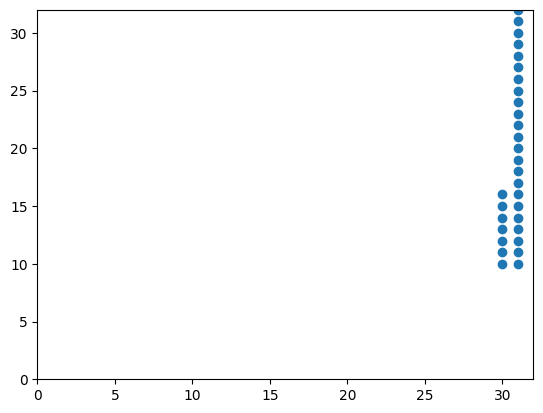

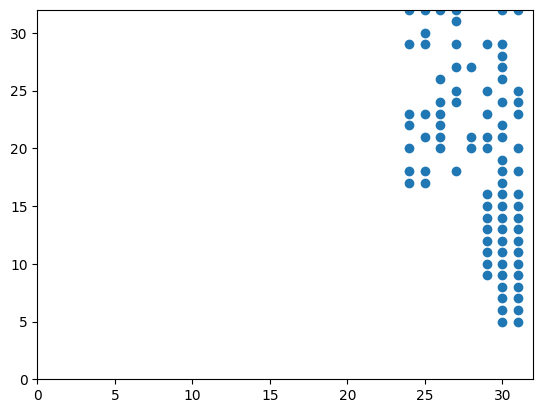

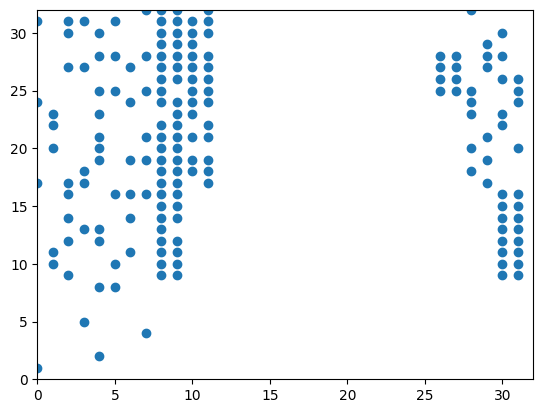

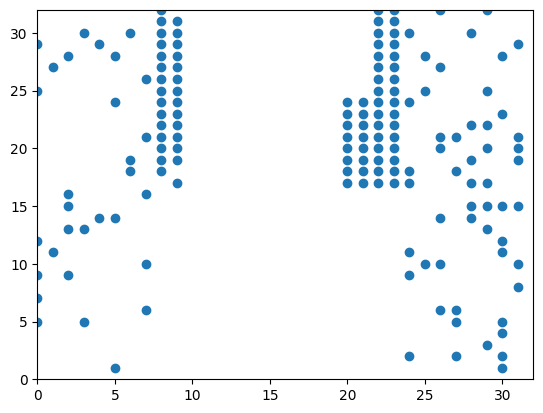

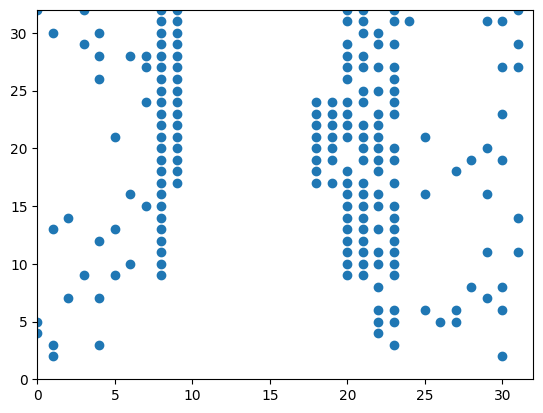

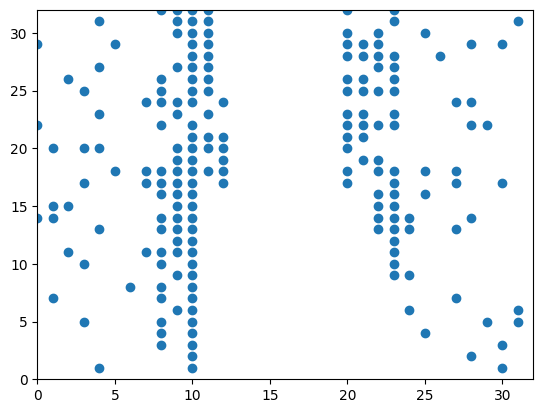

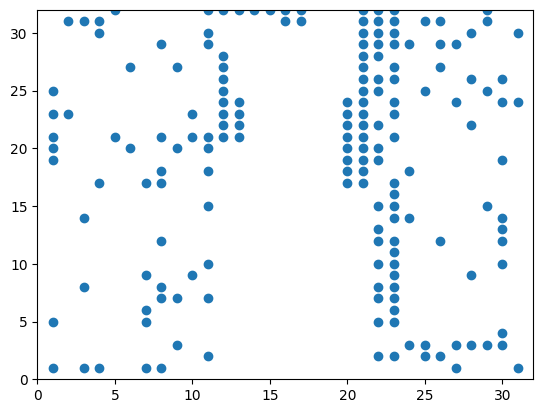

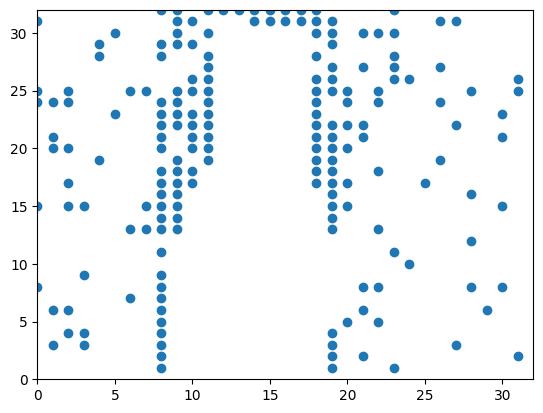

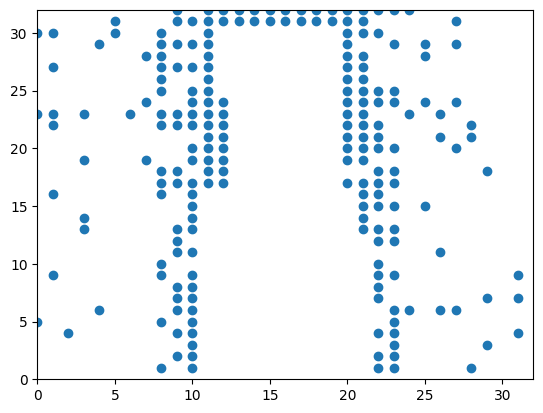

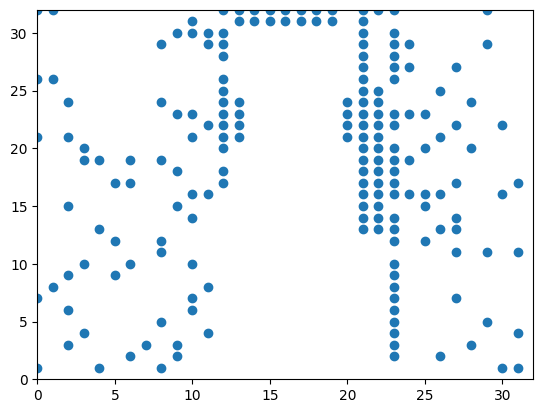

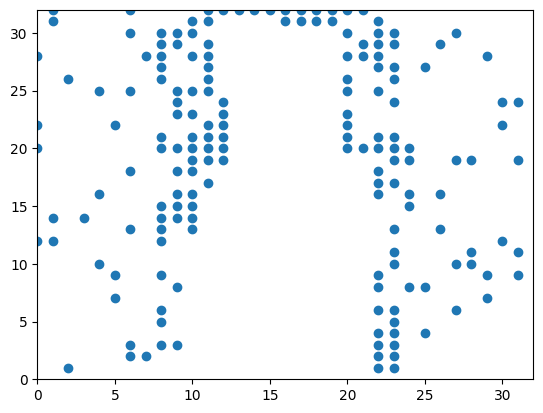

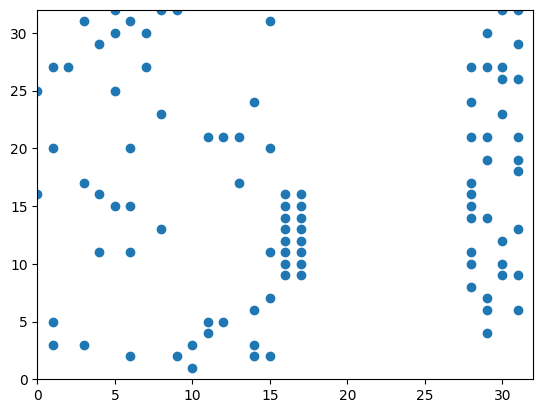

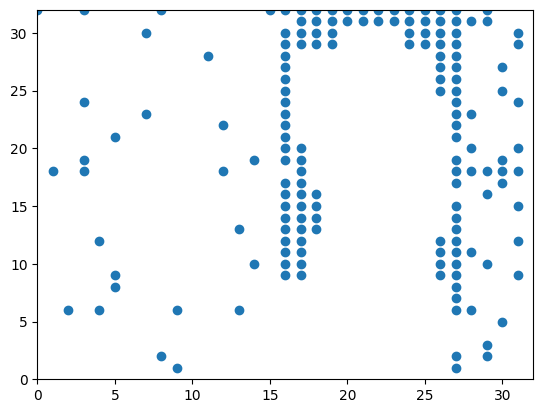

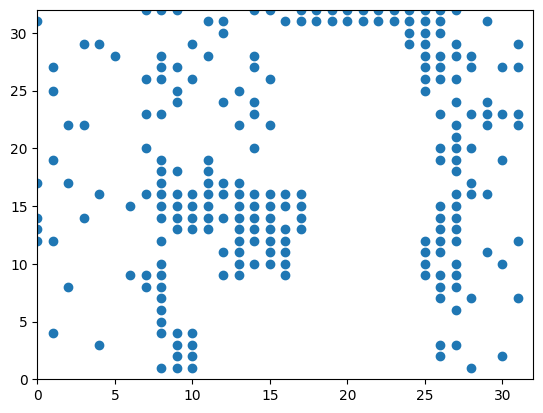

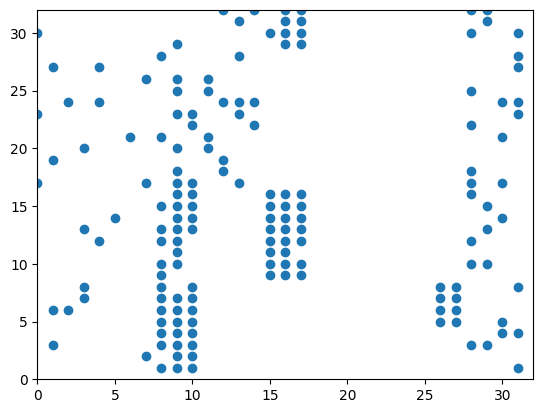

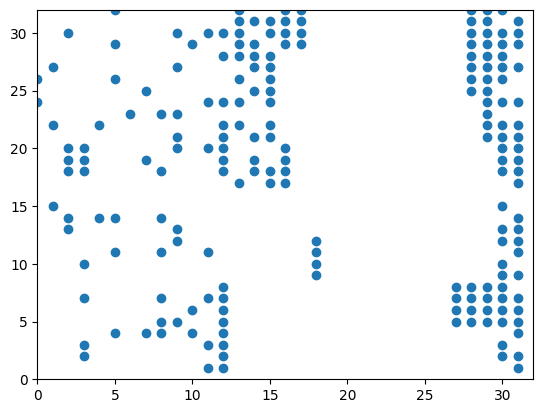

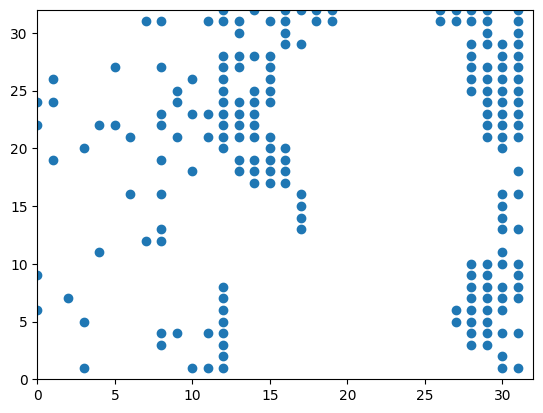

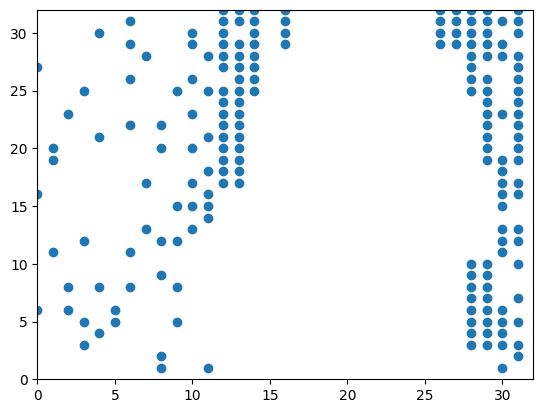

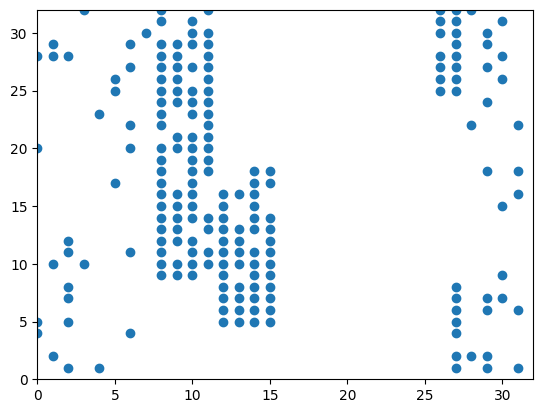

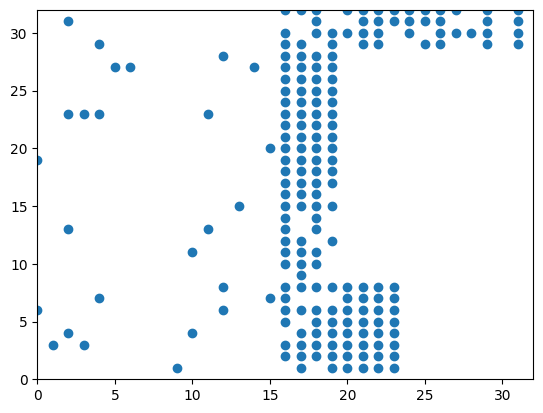

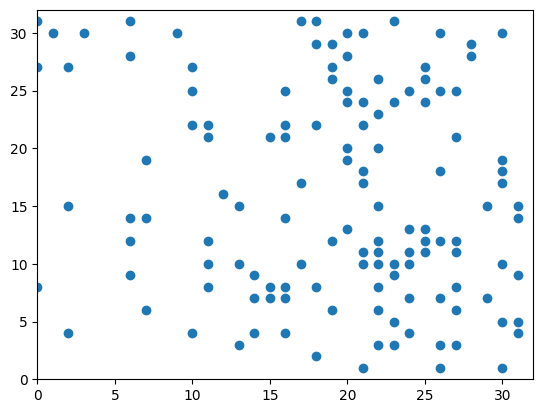

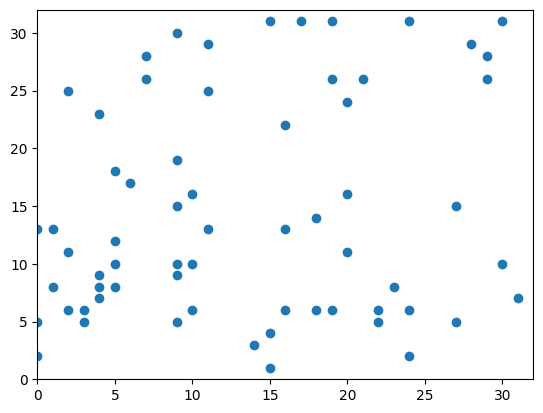

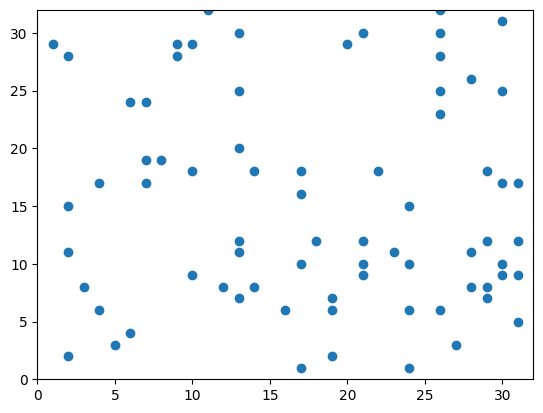

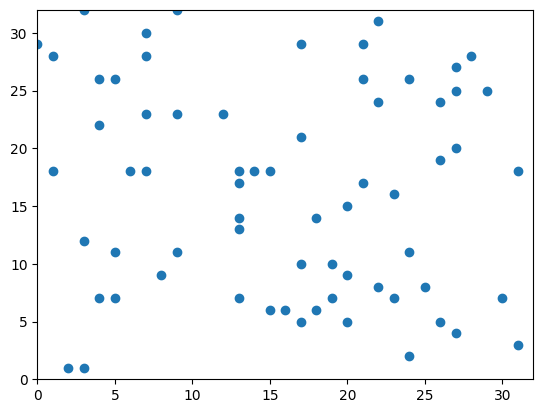

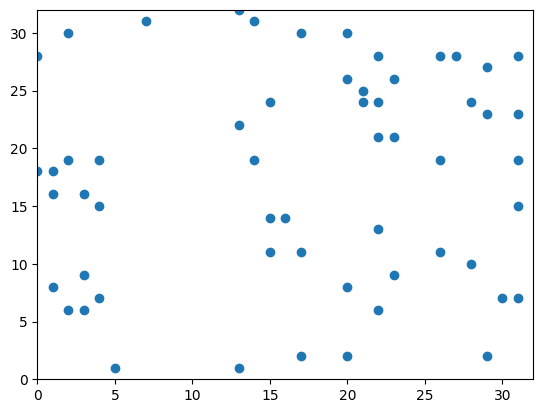

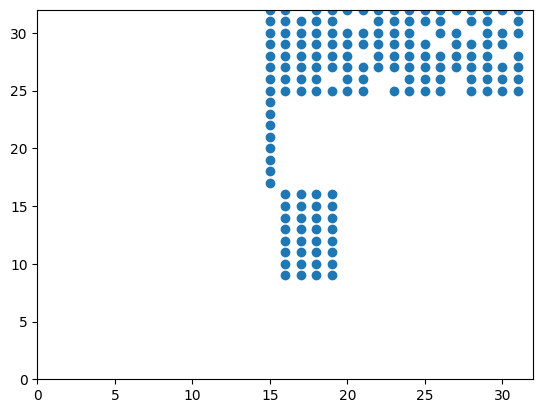

In [32]:
for i in range(26):
    run(i)